# Событийная аналитика пользователей мобильного приложения

Молодой стартап, который продаёт продукты питания, собрал данные о действиях пользователей своего мобильного приложения. Необходимо разобраться, как ведут себя пользователи при использовании приложения и проследить их путь до покупки, составив воронку продаж. В конце следует выявить влияние изменененных шрифтов на поведение пользователей. 

<b>Цель проекта</b>: 
1. Выявить шаги, на которых застревают пользователи.
2. Посмотреть, сколько пользователей уходят на каждом из шагов.
3. Составить воронку продаж и визуализировать ее.
4. Исследовать, как новые шрифты повлияли на основные пользовательские метрики.

<b>Ход исследования</b>

Данные для исследования я выгружу из файла <code>'/datasets/logs_exp.csv'</code>, после чего сделаю предобработку данных: проверю данные на актуальность, дубликаты, приведу их к нужному типу данных.

После я изучу данные подробнее: посмотрю, сколько человек попало в контрольные и экспериментальную группы, проверю, какие события описаны в файле, сколько событий приходится на одного пользователя и найду, за какой период представлены данные. 

На следующем шаге я составлю воронку событий и продемонстрирую типичный пользовательский опыт с приложением.

Последним этапом я проведу AB-тест и опишу результат от внедрения новых шрифтов.

<b>Навигация</b>

- [Загрузка файла с данными](#section_id1)


- [Подготовка данных](#section_id21)
    - [Подготовка столбцов](#section_id22)
    - [Преобразование типов данных](#section_id23)
    - [Проверка данных на дубликаты](#section_id24)
    
  
- [Изучение и проверка данных](#section_id3)
    - [События в датафрейме и количество пользователей](#section_id31)
    - [Распределение количества событий по дням](#section_id32)
    - [Фильтрация данных](#section_id33)
    
    
- [Изучение воронки событий](#section_id4)
    - [Самые популярные события](#section_id41)
    - [Количество пользователей на каждое событие](#section_id42)
    - [Воронка продаж](#section_id43)
    - [Процент пользователей, которые доходят от первого события до оплаты](#section_id44)
    
    
- [Изучение результатов эксперимента со шрифтами](#section_id5)
    - [Проверка контрольных групп на равенство](#section_id51)
    - [Проверка на разбиение по группам](#section_id52)
    
    
- [Общие выводы](#section_id6)

<a id='section_id1'></a>
## Загрузка файла с данными

In [1]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt 
from scipy import stats as st
import numpy as np
import math as mth
import datetime
from plotly import graph_objs as go 
import plotly.express as px

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


Познакомимся с датафреймом поближе на следующих шагах.

<a id='section_id2'></a>
## Подготовка данных

<a id='section_id21'></a>
### Подготовка столбцов

In [4]:
data.columns = ['event', 'userId', 'time', 'groupId']

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   event    244126 non-null  object
 1   userId   244126 non-null  int64 
 2   time     244126 non-null  int64 
 3   groupId  244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В датафрейме 244126 строк и 4 столбца: с названием события, айди пользователя, временем события и номером группы, в которую попал пользователь (246 и 247 - контрольные группы, а 248 экспериментальная) 

<a id='section_id22'></a>
### Преобразование типов данных

Изменим тип данных для столбца time и добавим столбец с датой.

In [6]:
data['time'] = pd.to_datetime(data['time'], unit='s')

In [7]:
data['date'] = pd.to_datetime(data['time'].dt.date)

In [8]:
data.head(10)

,event,userId,time,groupId,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


<a id='section_id23'></a>
### Проверка данных на дубликаты

Проверим получившийся датафрейм на строки-дубликаты.

In [9]:
duplicateRows = data[data.duplicated()]
duplicateRows

,event,userId,time,groupId,date
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247,2019-08-01
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248,2019-08-01
...,...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,247,2019-08-07
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,247,2019-08-07
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246,2019-08-07


Удалим 413 строк-дубликатов.

In [10]:
data.drop(index = duplicateRows.index, inplace=True)

In [11]:
data.shape[0]

243713

Теперь в датафрейме информация о 243713 разных событиях.

Данные очищены от повторяющихся строк, столбцы с датами приведены к нужному типу, пропуски отсутствуют.

<a id='section_id3'></a>
## Анализ данных

<a id='section_id31'></a>
### События в датафрейме и количество пользователей

In [61]:
events = data['event'].unique()
print(f'События: {", ".join(events)}')

События: MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, Tutorial


Всего в датафрейме 5 событий: попадание на главную страницу, страницу с успешной оплатой, с корзиной, с предложением об оплате и туториалом.

In [63]:
users = data['userId'].nunique()
print(f'Количество пользователей: {users}')

Количество пользователей: 7551


Всего в логе информация о действиях 7551 пользователей.

In [64]:
events_per_user = (data.groupby('userId')['event'].count())
print(f'Среднее количество событий на одного пользователя: {events_per_user.mean()}')

Среднее количество событий на одного пользователя: 32.27559263673685


На одного пользователя в среднем приходится 33 события. Посмотрим на медиану и выбросы, построив диаграмму размаха.

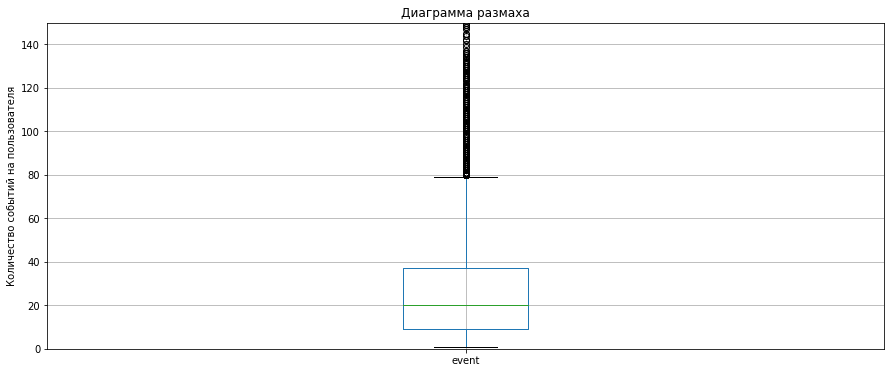

In [74]:
ax = events_per_user.reset_index().boxplot(column=['event'], figsize=(15, 6))
ax.set_ylim(0, 150)
plt.title('Диаграмма размаха')
plt.ylabel('Количество событий на пользователя')
plt.show()

Медиана расположена на отметке в 20 событий на пользователя, первый квантиль расположен около 10 (25% пользователей не совершают более 10 событий), а третий почти доходит до 40 (75% пользователей не совершают более 40 событий). Выбросы начинаются выше 80 событий на пользователя и, судя по диаграмме, это не единичные случаи.

<a id='section_id32'></a>
### Распределение количества событий по дням

In [75]:
events_per_user = events_per_user.reset_index()
events_per_user.columns = ['users', 'events']

In [76]:
print(f'Начало анализа: {data["date"].min()}, конец анализа: {data["date"].max()}')

Начало анализа: 2019-07-25 00:00:00, конец анализа: 2019-08-07 00:00:00


Первые данные в датафрейме за 25 июля 2019 года, последний день в выборке - 7 августа 2019 года.

Посмотрим на общий график распределения количества событий по дням.

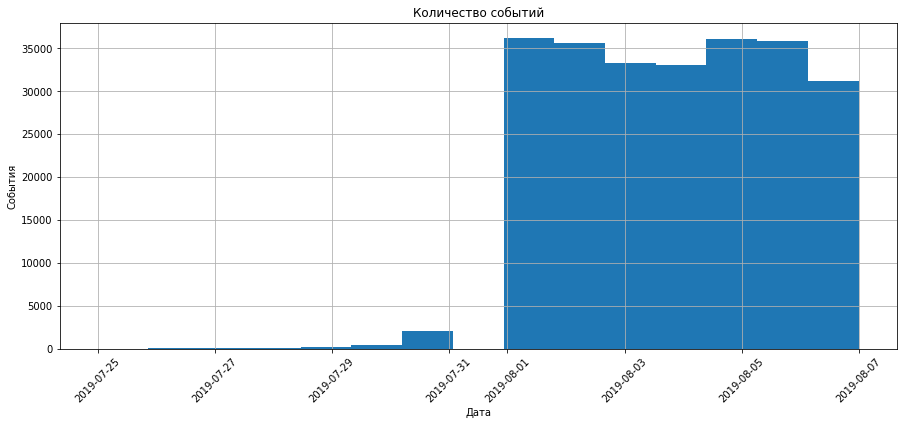

In [18]:
data['date'].hist(bins=15, figsize=(15,6))
plt.title('Количество событий')
plt.xticks(rotation=45) 
plt.xlabel('Дата')
plt.ylabel('События');

Посмотрим более мелкие детали, отобразив данные за 31 июля и 1 августа, чтобы понять, когда именно был запущен тест.

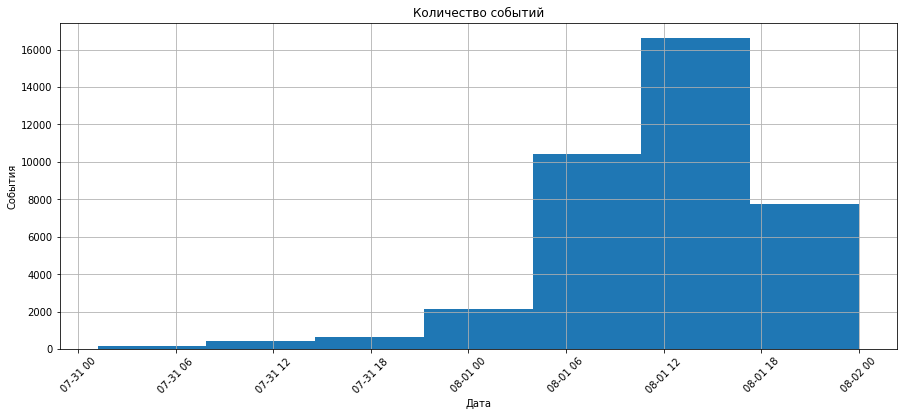

In [19]:
two_dates = data.query('date > "2019-07-30" and date < "2019-08-02"')
two_dates['time'].hist(bins=7, figsize=(15,6))
plt.title('Количество событий')
plt.xticks(rotation=45) 
plt.xlabel('Дата')
plt.ylabel('События');

Скорее всего, тест был запущен утром первого числа августа, так как за этот период резко возрастает количество событий - с 2000 до 10.000. 

Отбросим данные, которые содержат информацию о событиях до 2019-08-01.

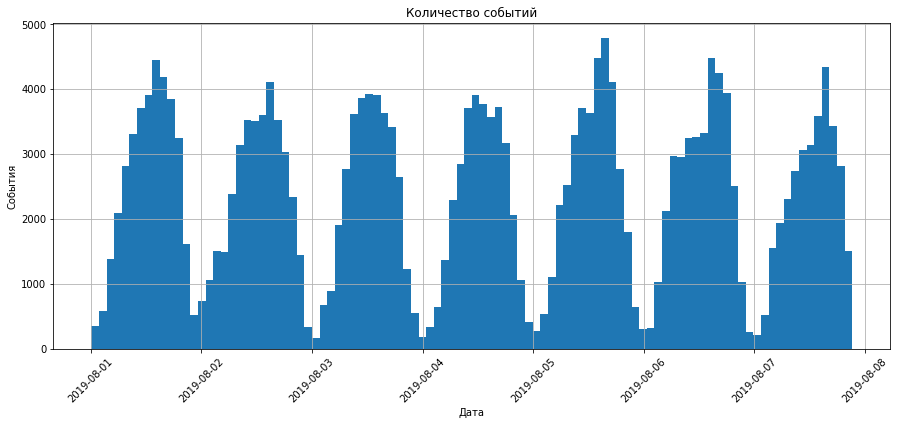

In [20]:
new_data = data.query('date > "2019-07-31"')
new_data['time'].hist(bins=100, figsize=(15,6))
plt.title('Количество событий')
plt.xticks(rotation=45) 
plt.xlabel('Дата')
plt.ylabel('События');

На этой гистограмме наглядно видно, что большая часть данных собрана днем - утром и ночью (края графиков) данных меньше.

Количество событий держится на высоком уровне для каждой даты - в среднем около отметки в 35.000. Посмотрим, сколько событий происходило до этой даты.

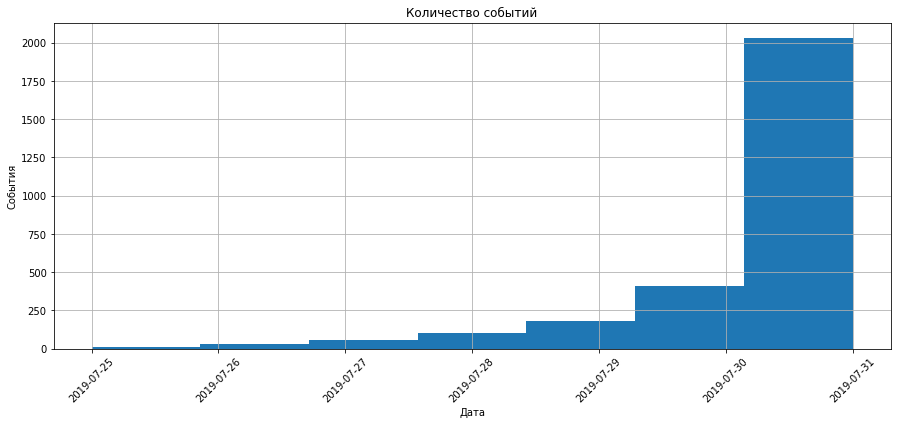

In [21]:
old_data = data.query('date <= "2019-07-31"')
old_data['date'].hist(bins=7, figsize=(15,6))
plt.title('Количество событий')
plt.xticks(rotation=45) 
plt.xlabel('Дата')
plt.ylabel('События');

In [22]:
events_per_day = old_data.groupby('date')['event'].count()
events_per_day

date
2019-07-25       9
2019-07-26      31
2019-07-27      55
2019-07-28     105
2019-07-29     184
2019-07-30     412
2019-07-31    2030
Name: event, dtype: int64

Самое большое количество событий пришлось на последний день - 2000 за день. Это лишь 6% от среднего количества в следующем месяце, поэтому данные в июле можно отбросить.

<a id='section_id33'></a>
### Фильтрация данных

In [78]:
deleted_data_rate = sum(old_data.groupby('date')['event'].count()) * 100 / sum(data.groupby('date')['event'].count())
print(f'Потерянные данные в %: {deleted_data_rate}')

Потерянные данные в %: 1.1595606307418973


Процент потерянных данных после того, как были отброшены старые, невысок - около 1%.

Проверим, что после фильтрации в датафрейме присутствуют пользователи из всех трёх экспериментальных групп.

In [24]:
new_data_users = new_data.groupby('groupId')['userId'].nunique()
new_data_users

groupId
246    2484
247    2513
248    2537
Name: userId, dtype: int64

In [25]:
old_data_users = data.groupby('groupId')['userId'].nunique()
old_data_users

groupId
246    2489
247    2520
248    2542
Name: userId, dtype: int64

По сгруппированным данным видно, что пользователи остались в группах в таких же пропорциях, как в оригинальном датафрейме. Посчитаем долю удаленных пользователей по группам.

In [26]:
deleted_users_rate = (old_data_users - new_data_users) * 100 / old_data_users
deleted_users_rate

groupId
246    0.200884
247    0.277778
248    0.196696
Name: userId, dtype: float64

После фильтрации данных в каждой группе убавилось меньше полпроцента пользователей - можно идти дальше.

<a id='section_id4'></a>
## Изучение воронки событий

<a id='section_id41'></a>
### Самые популярные события

In [27]:
events_freq = new_data['event'].value_counts().sort_values(ascending=False)
events_freq

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

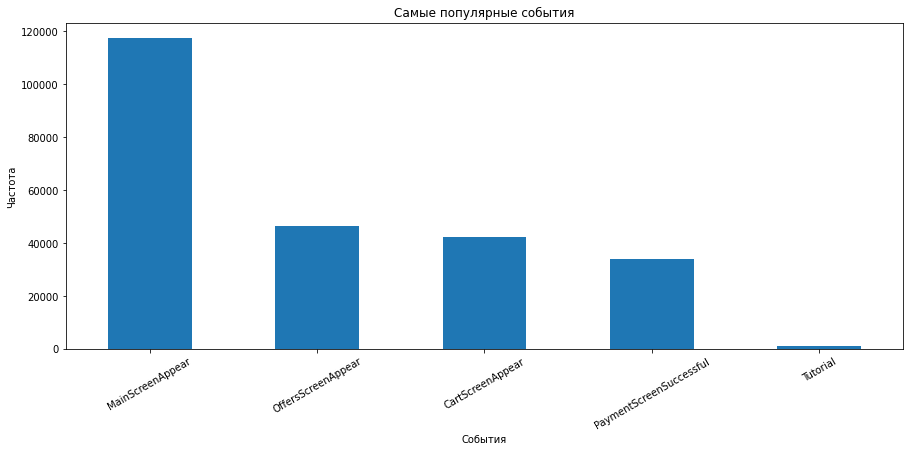

In [79]:
events_freq.plot(kind='bar', figsize=(15,6))
plt.title('Самые популярные события')
plt.xticks(rotation=30) 
plt.xlabel('События')
plt.ylabel('Частота');

Самое часто встречающееся событие, ожидаемо, попадание на страницу главного экрана (около половины всех событий). Реже пользователи попадают на экран с предложением товара и корзиной (это около 20% и 18%  от всех событий на каждое соответственно), еще меньше пользователей доходят до страницы с успешной оплатой (около 15%) и только 1000 (менее 1%) пользователей попадали на страницу с обучением.

<a id='section_id42'></a>
### Количество пользователей на каждое событие

In [84]:
pt_data = (new_data
           .pivot_table(values='userId', index='event', aggfunc='nunique')
           .sort_values(by='userId', ascending=False))

pt_data['rate'] = round(pt_data['userId'] / len(new_data['userId'].unique()), 2)
pt_data['%'] = round(pt_data['userId'] * 100 / len(new_data['userId'].unique()), 2)
pt_data

,userId,rate,%
event,,,
MainScreenAppear,7419,0.98,98.47
OffersScreenAppear,4593,0.61,60.96
CartScreenAppear,3734,0.50,49.56
PaymentScreenSuccessful,3539,0.47,46.97
Tutorial,840,0.11,11.15


Как и ожидалось, почти все пользователи попадают на главную страницу - это 98.5% пользователей. 61% пользователей переходят на страницу с предложением (товаром), 50% доходят до карзины, 46% ее оплачивают. Также 11% пользователей видят страницу с обучением. 

Предположительно в таком порядке и происходит воронка продаж: главная страница -> страница с предложением -> страница с корзиной -> страница с подтверждением оплаты. 

Десятая часть пользователей также проходит обучение, однако оно не является частью воронки, это опциональный шаг.

<a id='section_id43'></a>
### Воронка продаж

In [85]:
pt_data['clients'] = round(pt_data['userId'] * 100 / pt_data['userId'].shift(), 2).fillna('100')

In [86]:
pt_data[:4]

,userId,rate,%,clients
event,,,,
MainScreenAppear,7419,0.98,98.47,100
OffersScreenAppear,4593,0.61,60.96,61.91
CartScreenAppear,3734,0.50,49.56,81.3
PaymentScreenSuccessful,3539,0.47,46.97,94.78


На шаг с предложением товара после главной страницы переходит 62% пользователей, далее со страницы с товаром на страницу с корзиной переходит 81% пользователей, откуда 95% оставшихся доходят до корзины. 

Добавим визуализацию воронки продаж.

In [90]:
fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = pt_data[:4].reset_index()['event'],
    x = pt_data[:4].reset_index()['userId'],
    textinfo = "value+percent previous + percent initial",
    hoverinfo = "percent initial+percent previous")
    )



fig.update_layout(
    title={
        'text': "Воронка продаж",
        'y':0.87,
        'x':0.539,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<a id='section_id44'></a>
### Процент пользователей, которые доходят от первого события до оплаты

Проверим, сколько пользователей доходит от первого события до оплаты

In [34]:
print(f"До оплаты с главной страницы доходят {round(pt_data['userId'][3] * 100 / pt_data['userId'][0], 2)}% пользователей")

До оплаты с главной страницы доходят 47.7% пользователей


В этом разделе описаны и показаны воронки событий с количеством пользователей на каждой странице, выявлен процент пользователей, которые доходят с главной страницы до оплаты. <b>Показатель перехода с главной страницы на страницу с товаром можно попробовать увеличить, настроив более персонализированную рекламу и опираясь на покупки и предыдущие запросы пользователя.</b>


<a id='section_id5'></a>
## Изучение результатов эксперимента

In [35]:
group_users = new_data.groupby('groupId')['userId'].nunique()
group_users

groupId
246    2484
247    2513
248    2537
Name: userId, dtype: int64

В 246 группе 2484 пользователя, 247 - 2513, а в 248 - 2537.

Проверим, не участвуют ли пользователи сразу в нескольких группах.

In [36]:
intersections = (data
                 .groupby('userId')
                 .agg({'groupId': 'nunique'})
                 .query('groupId > 1')
                )
intersections

,groupId
userId,


Пользователей, которые входят в 2 и более групп, не нашлось.

<a id='section_id51'></a>
### Проверка контрольных групп на равенство

Сформулируем нулевую и альтернативную гипотезы о наличие равенства между контрольными группами 246 и 247. 

H0: Между выборками отсутствует статистическая разница.

H1: Между выборками присутствует статистическая разница. 

Пусть в successes будет количество пользователей, которые дошли до события.
В trials поместим количество пользователей, которые изначально были распределены в соответствующую группу.

С поправкой Бонферрони возьмем альфу за 0.003, предполагая, что мы будем тестировать группы на различия 16 раз.

In [37]:
first_group = new_data.query('groupId == 246')
first_group_data = first_group.groupby('event')['userId'].nunique()
first_group_data = first_group_data.sort_values(ascending=False)
first_group_data

event
MainScreenAppear           2450
OffersScreenAppear         1542
CartScreenAppear           1266
PaymentScreenSuccessful    1200
Tutorial                    278
Name: userId, dtype: int64

In [38]:
second_group = new_data.query('groupId == 247')
second_group_data = second_group.groupby('event')['userId'].nunique()
second_group_data = second_group_data.sort_values(ascending=False)
second_group_data

event
MainScreenAppear           2476
OffersScreenAppear         1520
CartScreenAppear           1238
PaymentScreenSuccessful    1158
Tutorial                    283
Name: userId, dtype: int64

In [39]:
alpha = .003

successes = np.array([first_group_data[0], second_group_data[0]])
trials = np.array([group_users.iloc[0], group_users.iloc[1]])

p1 = successes[0]/trials[0]

p2 = successes[1]/trials[1]

p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

difference = p1 - p2 

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

distr = st.norm(0, 1)

In [40]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам теста А-групп на равенство долей признаем нулевую гипотезу об отсутствии различий между выборками.

<a id='section_id52'></a>
### Проверка на разбиение по группам

In [41]:
all_events = new_data.pivot_table(index='event', values='userId', columns='groupId', aggfunc='nunique')

Посмотрим на каждое событие в разрезе количества пользователей, совершивших его, и проверим, есть ли статистически достоверное различие между группами по доле пользователей, совершивших событие. Проделаем тест для каждого события. Сначала сравним контрольные группы.

In [42]:
all_events.columns = [246, 247, 248]
all_events

,246,247,248
event,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


Сформулируем гипотезы о статистически достоверном различии между двумя контрольными группами.

H0: Между выборками отсутствует статистическая разница.

H1: Между выборками присутствует статистическая разница. 

Напишем функцию, чтобы автоматизировать проверку.

In [43]:
def check_diff(df):
    alpha = .003

    successes = np.array([df[246], df[247]])
    trials = np.array([group_users.iloc[0], group_users.iloc[1]])

    p1 = successes[0]/trials[0]

    p2 = successes[1]/trials[1]

    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    

    if p_value < alpha:
        return f'p-значение: {p_value}.\nОтвергаем нулевую гипотезу: между долями есть значимая разница'
    else:
        return f'p-значение: {p_value}.\nНе получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

In [44]:
for i in range(4):
    print(f'Результат для события {all_events.index[i]}: {check_diff(all_events.iloc[i])}\n')

Результат для события CartScreenAppear: p-значение: 0.22883372237997213.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события MainScreenAppear: p-значение: 0.7570597232046099.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события OffersScreenAppear: p-значение: 0.2480954578522181.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события PaymentScreenSuccessful: p-значение: 0.11456679313141849.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Делаем вывод, что разбиение на группы работает корректно, доли не отличаются статистически. 

Теперь проверим каждую контрольную группу с экспериментальной.

In [45]:
def check_diff_246_experiment(df):
    
    alpha = .003

    successes = np.array([df[246], df[248]])
    trials = np.array([group_users.iloc[0], group_users.iloc[2]])

    p1 = successes[0]/trials[0]

    p2 = successes[1]/trials[1]

    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    if p_value < alpha:
        return f'p-значение: {p_value}.\nОтвергаем нулевую гипотезу: между долями есть значимая разница'
    else:
        return f'p-значение: {p_value}.\nНе получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

In [46]:
for i in range(4):
    print(f'Результат для события {all_events.index[i]}: {check_diff_246_experiment(all_events.iloc[i])}\n')

Результат для события CartScreenAppear: p-значение: 0.07842923237520116.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события MainScreenAppear: p-значение: 0.2949721933554552.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события OffersScreenAppear: p-значение: 0.20836205402738917.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события PaymentScreenSuccessful: p-значение: 0.2122553275697796.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимых различий нет. Сравним экспериментальную группу со шрифтами с 247 группой.

In [47]:
def check_diff_247_experiment(df):
    
    alpha = .003

    successes = np.array([df[247], df[248]])
    trials = np.array([group_users.iloc[1], group_users.iloc[2]])

    p1 = successes[0]/trials[0]

    p2 = successes[1]/trials[1]

    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    if p_value < alpha:
        return f'p-значение: {p_value}.\nОтвергаем нулевую гипотезу: между долями есть значимая разница'
    else:
        return f'p-значение: {p_value}.\nНе получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

In [48]:
for i in range(4):
    print(f'Результат для события {all_events.index[i]}: {check_diff_247_experiment(all_events.iloc[i])}\n')

Результат для события CartScreenAppear: p-значение: 0.5786197879539783.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события MainScreenAppear: p-значение: 0.4587053616621515.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события OffersScreenAppear: p-значение: 0.9197817830592261.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события PaymentScreenSuccessful: p-значение: 0.7373415053803964.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Различий снова нет. Объединим две контрольные группы и сравним с экспериментальной.

In [49]:
def check_diff_controls_experiment(df):
    
    alpha = .003

    successes = np.array([df[246] + df[247], df[248]])
    trials = np.array([group_users.iloc[1] + group_users.iloc[0], group_users.iloc[2]])

    p1 = successes[0]/trials[0]

    p2 = successes[1]/trials[1]

    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    if p_value < alpha:
        return f'p-значение: {p_value}.\nОтвергаем нулевую гипотезу: между долями есть значимая разница'
    else:
        return f'p-значение: {p_value}.\nНе получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'

In [50]:
for i in range(4):
    print(f'Результат для события {all_events.index[i]}: {check_diff_controls_experiment(all_events.iloc[i])}\n')

Результат для события CartScreenAppear: p-значение: 0.18175875284404386.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события MainScreenAppear: p-значение: 0.29424526837179577.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события OffersScreenAppear: p-значение: 0.43425549655188256.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результат для события PaymentScreenSuccessful: p-значение: 0.6004294282308704.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



У объединенных контрольных групп и экспериментальной так же нет статистически достоверных различий. Можно сделать вывод, что шрифты не повлияли на поведение пользователей. 

Всего проведено 16 проверок статистических гипотез, различий не выявлено. Уровень значимости выбран на отметке в 0.003, так как по поправке Бонферрони для снижения вероятности получения ложноположительного результата необходимо выбранный уровень значимости (0.05) поделить на количество проверок гипотез.

<a id='section_id6'></a>
# Общие выводы

В ходе проекта отсеяны информативные данные для анализа, выявлена воронка продаж, количество и процент пользователей, которые отсеиваются на каждом шаге и установлено, что измененные шрифты значимо не повлияли на поведение пользователей ни в одном из 16 тестов. 

Рекомендуется обратить внимание на страницу с предложением и доработать ее, так как отсев пользователей в 40% довольно высокий показатель. Гипотеза с новыми шрифтами не показала эффективности и не должна быть принята к разработке.